# Mempool Data preprocessing to JSON array 

In [70]:
import json 
import os.path
import math
import matplotlib.pyplot as plt
import numpy as np

INITIAL_NUM_ZOMBIE_CHANNELS = 57000 # Estimated as of Feb 4, 2022
LN_CLOSING_CHANNEL_DELAY = 1000 # ~ 1 week

accumulated_txs = 0 # transactions that would have been already confirmed without the zombie channels transactions

# We read the file containing mempool historical data

i = 1
mempool_data_json_string = ''

while os.path.exists(f"mempool/{i}_mempool"):
    mempool_data_file = open(f"mempool/{i}_mempool", mode = 'r')
    mempool_data_content = mempool_data_file.read()
    
    # We replace call() from file content (it is used for the website to load the JSONP)
    mempool_data_content = mempool_data_content[5 : len(mempool_data_content) - 2]
    
    # We remove the first and the last square brackets, then I will add them again at the end before parsing the JSON,
    # in order to obtain a single merged json of all the mempool data
    mempool_data_content = mempool_data_content[1:]
    mempool_data_content = mempool_data_content[:-1]

    mempool_data_content += ','

    mempool_data_json_string += mempool_data_content
    mempool_data_file.close()

    i += 1

mempool_data_json_string = mempool_data_json_string[:-1]
mempool_data_json_string = f"[{mempool_data_json_string}]"

# Parsing JSON file

mempool_data = json.loads(mempool_data_json_string) 

# Parsing blocks input data taken from a full Bitcoin Node

blocks_file = open(f"blocks/blocks.json", mode = 'r')
blocks_data_content = blocks_file.read()
blocks_data = json.loads(blocks_data_content)

# Zombie Attack Simulation using mempool historical data

In [71]:
# Data taken from https://jochen-hoenicke.de/queue/#BTC,all,count

# These are the fee ranges supported in the dataset (for example txs that have a fee rate from 10 to 12 with 12 excluded are grouped together and so on)
fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

# problematic intervals that should not be considerated (probably the BTC nodes of the owner went offline for a while)
PROBLEMATIC_INTERVALS = [[1516728783, 1516729440], [1515943500, 1515944160]] 

# if highest_priority == True, then txs are put in the first positions of the queue (used when we are considering a fee level that is greater than the maximum fee level in our dataset: in this case, we
# want that our transactions are those with the highest priority in the mempool)
def simulate(mempool_data, blocks_data, first_block_height_of_simulation, fee_index_in_ranges, num_zombie_channels, highest_priority=False, dynamic=False, beta=1, step=1, plot_distribution=False, percentage_to_be_closed=1.0):
    
    first_height = blocks_data[0]["height"]
    blocksCounter = 0
    last_total_tx_count = None
    last_tx_count_per_fee_level = None 
    initial_tx_with_same_fee = 0 # Number of transactions with the same fee as the closing channel txs, at the begniinning of the simulation
    current_fee = fee_ranges[fee_index_in_ranges]

    plot_blocks = []
    plot_remaining_zombie_channels = []
    
    if not highest_priority:
        initial_tx_with_same_fee = mempool_data[0][1][fee_index_in_ranges]

    for snapshot in mempool_data:
        timestamp = snapshot[0]
        tx_count_per_fee_level = snapshot[1] # Array that contains, for each fee level in `fee_ranges`, the corresponding number of transactions currently in the mempool
        total_tx_count = sum(tx_count_per_fee_level)

        if last_total_tx_count is None and last_tx_count_per_fee_level is None:
            # First snapshot
            last_total_tx_count = total_tx_count
            last_tx_count_per_fee_level = tx_count_per_fee_level
        else:
            is_in_problematic_interval = False

            for interval in PROBLEMATIC_INTERVALS:
                if(timestamp >= interval[0] and timestamp < interval[1]):
                    is_in_problematic_interval = True
                    break

            if not is_in_problematic_interval and total_tx_count < last_total_tx_count:
                
                # New Block detected
                blocksCounter += 1
                
                #estimated_num_tx_in_block = last_total_tx_count - total_tx_count
                # `first_block_height_of_simulation` is the first block that we will encounter in our simulation (must be manually found using a block explorer)
                # `first_height` is the first blocck number in our blocks dataset
                # These two parameter could differ based on the collected block dataset and the time frame taken into consideration for the simulation.
                num_tx_in_block = blocks_data[(first_block_height_of_simulation - first_height + blocksCounter) - 1]["n_transactions"]

                tx_with_higher_fee = 0 # Number of transactions that have an higher fee than the closing channel transactions
                
                index = fee_index_in_ranges + 1

                #print("fee_index_in_ranges: ", fee_index_in_ranges)

                while index < len(tx_count_per_fee_level):
                    tx_with_higher_fee = tx_with_higher_fee + last_tx_count_per_fee_level[index]
                    index = index + 1

                if(num_tx_in_block > tx_with_higher_fee): # if the new block can contain transactions with the level of fee we are considering for closing channel transactions
                    
                    # random ordering of all the tx with this fee level or ordered queue based on arrival time

                    number_of_confirmed_tx_in_this_fee_level = num_tx_in_block - tx_with_higher_fee 

                    if(initial_tx_with_same_fee >= number_of_confirmed_tx_in_this_fee_level):
                        initial_tx_with_same_fee -= number_of_confirmed_tx_in_this_fee_level
                    else:
                        if(initial_tx_with_same_fee > 0):
                            number_of_confirmed_tx_in_this_fee_level -= initial_tx_with_same_fee
                            initial_tx_with_same_fee = 0

                        # In this case, differently from the other type of attack, we dont have to take into account
                        # the fact that the LN transactions that we are monitoring are "replacing" some other transactions that
                        # are removed from the mempool in the dataset, because they would be confirmed after all the LN txs (LN txs in this
                        # case are considered as simultaneously submitted, they are "grouped" together), therefore we are not interested
                        # in keeping track of them.
                        num_zombie_channels -= number_of_confirmed_tx_in_this_fee_level    

                if(dynamic and blocksCounter % step == 0):
                    new_fee = current_fee * beta
                    fee_index_in_ranges = find_index_of_fee_in_ranges(new_fee)
                    current_fee = new_fee

                if(plot_distribution):
                    plot_blocks.append(LN_CLOSING_CHANNEL_DELAY + blocksCounter)
                    plot_remaining_zombie_channels.append(num_zombie_channels)

            last_total_tx_count = total_tx_count
            last_tx_count_per_fee_level = tx_count_per_fee_level

        if(num_zombie_channels <= INITIAL_NUM_ZOMBIE_CHANNELS - (INITIAL_NUM_ZOMBIE_CHANNELS * percentage_to_be_closed)):
            
            if(plot_distribution):
                fig, ax = plt.subplots()
                ax.grid(True) 
                plt.plot(plot_blocks, plot_remaining_zombie_channels)
                plt.xlabel('Blocks') 
                plt.ylabel(f'Number of zombie channels')
                plt.show() 

            return blocksCounter

    return None

def find_index_of_fee_in_ranges(fee):
    fee_index = 0

    i = 1

    while i < len(fee_ranges):
        if fee_ranges[i-1] <= fee and fee < fee_ranges[i]:
            fee_index = i-1
            return fee_index
        i = i + 1

    return fee_ranges[len(fee_ranges) - 1] # maximum fee index

def get_median_index_fee(first_snapshot):

    initial_tx_count_per_fee_level = first_snapshot[1]
    initial_tx_count_per_fee_level = initial_tx_count_per_fee_level[1:]
    total_tx_count = sum(initial_tx_count_per_fee_level)

    # Computing the index of the median fee in `fee_ranges` (in the first snapshot of the simulation)

    acc = 0
    i = 0
    median_index = 0

    for c in initial_tx_count_per_fee_level:
        acc = acc + c
        if acc >= total_tx_count / 2:
            # As soon as we detected that half of all the txs in the mempool have a lower fee 
            # than the current fee index (and half have an higher fee), than this is the median fee index
            median_index = i
            break
        else:
            i = i + 1  

    return median_index    
       
def get_average_index_fee(first_snapshot): # TODO should consider 0 in `fee_ranges`? (it is always empty)

    initial_tx_count_per_fee_level = first_snapshot[1]
    initial_tx_count_per_fee_level = initial_tx_count_per_fee_level[1:]
    total_tx_count = sum(initial_tx_count_per_fee_level)

    # Computing the index of the average fee in `fee_ranges` (in the first snapshot of the simulation)

    acc = 0
    i = 0

    while(i < len(initial_tx_count_per_fee_level)):
        acc = acc + (fee_ranges[i] * initial_tx_count_per_fee_level[i])
        i = i + 1

    avg_fee = acc / total_tx_count

    average_index = find_index_of_fee_in_ranges(avg_fee)

    return average_index    

# STATIC CASE

# Blocks needed to close all channels with average and median fee

X-axis: number blocks seen in the simulation, Y-axis: number of zombie channels still open


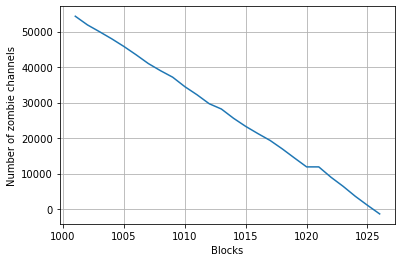

1026 blocks to close all channels with fee in the range  600 - 699


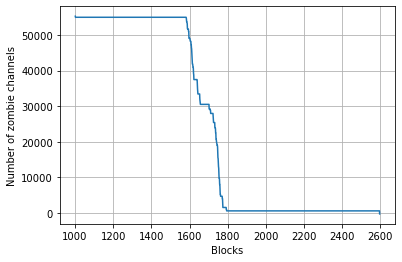

2597 blocks to close all channels with fee in the range  80 - 99


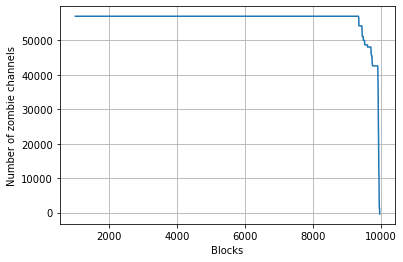

9971 blocks to close all channels with median fee ( = 1 )


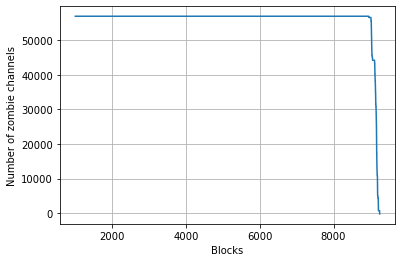

9248 blocks to close all channels with average fee ( = 4 )


In [79]:
fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

median_index = get_median_index_fee(mempool_data[0])
average_index = get_average_index_fee(mempool_data[0])

# Our mempool data first snapshot is on Dec 6 at 06:39 (timestamp 1512563944), therefore the first block that we will encounter will be 
# the block at height 497928 (https://www.blockchain.com/btc/block/497928) 

print("X-axis: number blocks seen in the simulation, Y-axis: number of zombie channels still open")

fee_index = 30
needed_blocks = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, fee_index, INITIAL_NUM_ZOMBIE_CHANNELS, plot_distribution=True)
print(needed_blocks, "blocks to close all channels with fee in the range ", fee_ranges[fee_index], "-", fee_ranges[fee_index + 1] - 1)

fee_index = 20
needed_blocks = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, fee_index, INITIAL_NUM_ZOMBIE_CHANNELS, plot_distribution=True)
print(needed_blocks, "blocks to close all channels with fee in the range ", fee_ranges[fee_index], "-", fee_ranges[fee_index + 1] - 1)

blocks_to_close_all_channels_with_median_fee = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, median_index, INITIAL_NUM_ZOMBIE_CHANNELS, plot_distribution=True)
print(blocks_to_close_all_channels_with_median_fee, "blocks to close all channels with median fee ( =", fee_ranges[median_index], ")")

blocks_to_close_all_channels_with_avg_fee = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, average_index, INITIAL_NUM_ZOMBIE_CHANNELS, plot_distribution=True)
print(blocks_to_close_all_channels_with_avg_fee, "blocks to close all channels with average fee ( =", fee_ranges[average_index], ")")


# Simulation considering all the fee levels supported by the dataset (blocks needed to close all channels as a function of the fee chosen for the closing channels transactions)

13164 blocks to close all channels with fee = 0
9971 blocks to close all channels with fee = 1
9920 blocks to close all channels with fee = 2
9328 blocks to close all channels with fee = 3
9248 blocks to close all channels with fee = 4
9152 blocks to close all channels with fee = 5
9055 blocks to close all channels with fee = 6
9027 blocks to close all channels with fee = 7
8951 blocks to close all channels with fee = 8
8779 blocks to close all channels with fee = 10
8659 blocks to close all channels with fee = 12
8625 blocks to close all channels with fee = 14
8612 blocks to close all channels with fee = 17
8572 blocks to close all channels with fee = 20
8518 blocks to close all channels with fee = 25
8276 blocks to close all channels with fee = 30
8054 blocks to close all channels with fee = 40
7959 blocks to close all channels with fee = 50
4935 blocks to close all channels with fee = 60
4853 blocks to close all channels with fee = 70
2597 blocks to close all channels with fee = 80


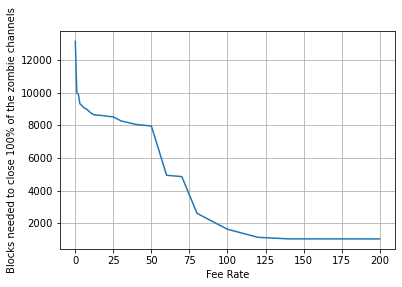

In [73]:
fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200]

fig, ax = plt.subplots()
ax.grid(True)

needed_blocks = [] # number of blocks needed to close all the zombie channels

i = 0

while(i < len(fee_ranges)):
    blocks_to_close_all_channels = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, i, INITIAL_NUM_ZOMBIE_CHANNELS)

    print(blocks_to_close_all_channels, "blocks to close all channels with fee =", fee_ranges[i])

    needed_blocks.append(blocks_to_close_all_channels)
    i += 1

plt.plot(fee_ranges, needed_blocks)
plt.xlabel('Fee Rate') 
plt.ylabel(f'Blocks needed to close 100% of the zombie channels')
plt.show()    


# Simulation considering an alpha parameter that indicates the aggressiveness of users that are trying to close channels (blocks needed to close all channels as a function of alpha parameter)

13164 blocks to close all channels with alpha = 0.0
13164 blocks to close all channels with alpha = 0.01
13164 blocks to close all channels with alpha = 0.02
13164 blocks to close all channels with alpha = 0.03
9971 blocks to close all channels with alpha = 0.04
9971 blocks to close all channels with alpha = 0.05
9971 blocks to close all channels with alpha = 0.06
9971 blocks to close all channels with alpha = 0.07
9920 blocks to close all channels with alpha = 0.08
9920 blocks to close all channels with alpha = 0.09
9920 blocks to close all channels with alpha = 0.1
9920 blocks to close all channels with alpha = 0.11
9328 blocks to close all channels with alpha = 0.12
9328 blocks to close all channels with alpha = 0.13
9328 blocks to close all channels with alpha = 0.14
9328 blocks to close all channels with alpha = 0.15
9248 blocks to close all channels with alpha = 0.16
9248 blocks to close all channels with alpha = 0.17
9248 blocks to close all channels with alpha = 0.18
9248 block

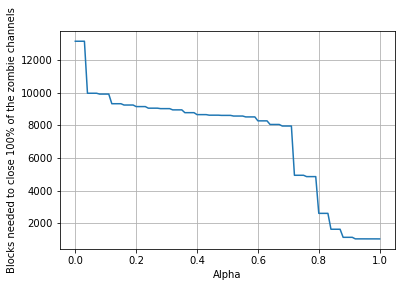

In [74]:
fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200]

fig, ax = plt.subplots()
ax.grid(True)

needed_blocks = []

alphas = np.arange(start=0, stop=1.01, step=0.01)

for alpha in alphas:
    
    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges >= len(fee_ranges) - 1):
       fee_index_in_ranges = len(fee_ranges) - 1
    
    blocks_to_close_all_channels = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, fee_index_in_ranges, INITIAL_NUM_ZOMBIE_CHANNELS)

    print(blocks_to_close_all_channels, "blocks to close all channels with alpha =", alpha)
    
    needed_blocks.append(blocks_to_close_all_channels)

plt.plot(alphas, needed_blocks)
plt.xlabel('Alpha') 
plt.ylabel(f'Blocks needed to close 100% of the zombie channels')
plt.show() 

# Simulation with a fixed average fee (at the time of arrival of the closing channel transactions): plotting the blocks needed to close all channels as a function of the attacked fraction of the max-cut

9012 blocks to close all channels with average fee and max-cut size = 570.0
9013 blocks to close all channels with average fee and max-cut size = 1140.0
9021 blocks to close all channels with average fee and max-cut size = 1710.0
9021 blocks to close all channels with average fee and max-cut size = 2280.0
9022 blocks to close all channels with average fee and max-cut size = 2850.0
9023 blocks to close all channels with average fee and max-cut size = 3420.0000000000005
9023 blocks to close all channels with average fee and max-cut size = 3989.9999999999995
9023 blocks to close all channels with average fee and max-cut size = 4560.0
9027 blocks to close all channels with average fee and max-cut size = 5130.0
9029 blocks to close all channels with average fee and max-cut size = 5699.999999999999
9029 blocks to close all channels with average fee and max-cut size = 6270.0
9029 blocks to close all channels with average fee and max-cut size = 6840.0
9029 blocks to close all channels with ave

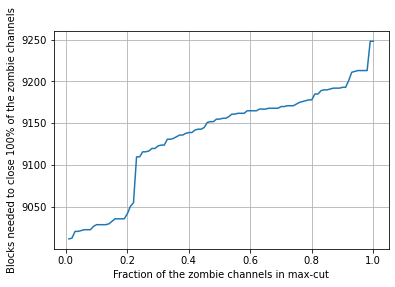

In [75]:
fig, ax = plt.subplots()
ax.grid(True)

fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]
needed_blocks = []

average_index = get_average_index_fee(mempool_data[0])

fractions = np.arange(start=0.01, stop=1.01, step=0.01)

for fraction in fractions:
    zombie_channels = fraction * INITIAL_NUM_ZOMBIE_CHANNELS

    blocks_to_close_all_channels = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, average_index, zombie_channels)

    print(blocks_to_close_all_channels, "blocks to close all channels with average fee and max-cut size =", zombie_channels)
    
    needed_blocks.append(blocks_to_close_all_channels)

plt.plot(fractions, needed_blocks)
plt.xlabel('Fraction of the zombie channels in max-cut') 
plt.ylabel(f'Blocks needed to close 100% of the zombie channels')
plt.show() 

# Simulation with a fixed average fee (at the time of arrival of the closing channel transactions): plotting the blocks needed to close all channels as a function of the size of the max-cut (from 60k channels to 1 million channels)

9248 blocks to close all channels with average fee and max-cut size = 57000
9249 blocks to close all channels with average fee and max-cut size = 58000
9255 blocks to close all channels with average fee and max-cut size = 59000
9266 blocks to close all channels with average fee and max-cut size = 60000
9267 blocks to close all channels with average fee and max-cut size = 61000
9273 blocks to close all channels with average fee and max-cut size = 62000
9277 blocks to close all channels with average fee and max-cut size = 63000
9287 blocks to close all channels with average fee and max-cut size = 64000
9295 blocks to close all channels with average fee and max-cut size = 65000
9295 blocks to close all channels with average fee and max-cut size = 66000
9299 blocks to close all channels with average fee and max-cut size = 67000
9301 blocks to close all channels with average fee and max-cut size = 68000
9302 blocks to close all channels with average fee and max-cut size = 69000
9303 blocks 

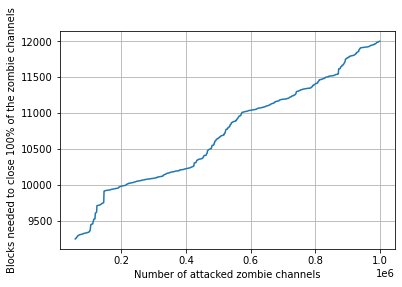

In [76]:
fig, ax = plt.subplots()
ax.grid(True)

fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]
needed_blocks = []

average_index = get_average_index_fee(mempool_data[0])

for zombie_channels in range(INITIAL_NUM_ZOMBIE_CHANNELS, 1000000, 1000):
    
    blocks_to_close_all_channels = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, average_index, zombie_channels)

    print(blocks_to_close_all_channels, "blocks to close all channels with average fee and max-cut size =", zombie_channels)
    
    needed_blocks.append(blocks_to_close_all_channels)

plt.plot(range(INITIAL_NUM_ZOMBIE_CHANNELS, 1000000, 1000), needed_blocks)
plt.xlabel('Number of attacked zombie channels') 
plt.ylabel(f'Blocks needed to close 100% of the zombie channels')
plt.show() 

# DYNAMIC CASE

# Simulation with a fixed number of initial zombie channels, fixed alpha parameter, fixed beta (factor of growth of the fee of the transactions still to be confirmed): blocks needed to close all zombie channels as a function of step parameter

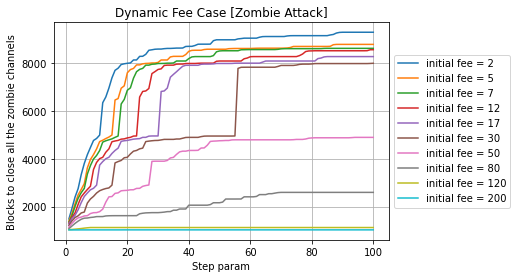

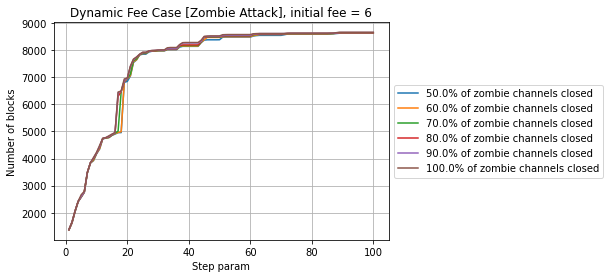

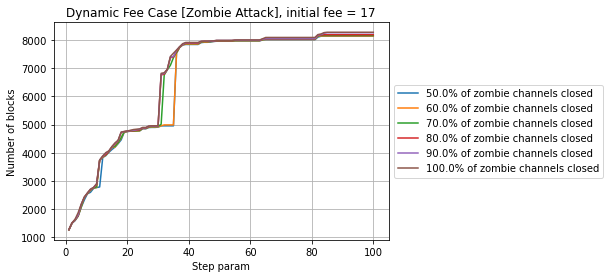

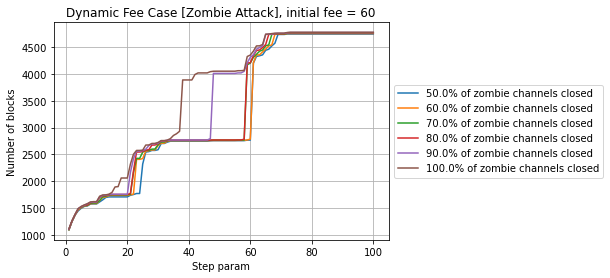

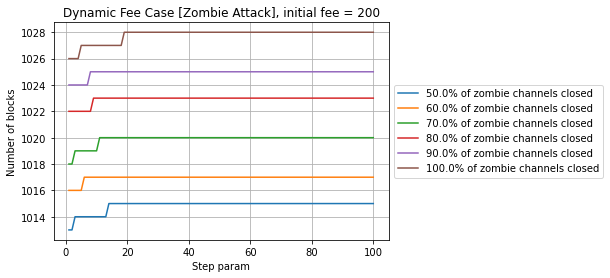

In [77]:
# Dynamic Case
# beta: factor of growth of the fee (new_fee = alpha * beta)
# step: number of blocks after which the fee is increased
# gamma: percentage of transactions that are replaced (TODO)

fee_ranges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200]

legend = []
alphas = np.linspace(0.1, 1, num=10)
beta = 1.01 # 1 percent fixed
steps = np.linspace(1, 100, num=100)

fig, ax = plt.subplots()
ax.grid(True)

for alpha in alphas:

    highest_priority = False

    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges > len(fee_ranges) - 1):
        highest_priority = True
        fee_index_in_ranges = len(fee_ranges) - 1

    initial_fee = fee_ranges[fee_index_in_ranges]

    needed_blocks = []

    for step in steps:
        needed_blocks.append(LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, fee_index_in_ranges, INITIAL_NUM_ZOMBIE_CHANNELS, highest_priority=highest_priority, dynamic=True, beta=beta, step=step))

    legend.append(f"initial fee = {initial_fee}") # , beta = {beta}

    plt.plot(steps, needed_blocks)


plt.title('Dynamic Fee Case [Zombie Attack]')
plt.xlabel('Step param') 
plt.ylabel('Blocks to close all the zombie channels') 
plt.legend(labels=legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

######

alphas = [0.25, 0.5, 0.75, 1]
percentages_to_be_closed = np.linspace(0.5, 1.0, num=6)
# beta still fixed to 1%

for alpha in alphas:

    highest_priority = False

    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges > len(fee_ranges) - 1):
        highest_priority = True
        fee_index_in_ranges = len(fee_ranges) - 1

    initial_fee = fee_ranges[fee_index_in_ranges]

    fig, ax = plt.subplots()
    ax.grid(True)

    legend = []

    for percentage in percentages_to_be_closed:
        needed_blocks = []
        for step in steps:
            needed_blocks.append(LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, blocks_data, 497928, fee_index_in_ranges, INITIAL_NUM_ZOMBIE_CHANNELS, highest_priority=highest_priority, dynamic=True, beta=beta, step=step, percentage_to_be_closed=percentage))
        legend.append(f"{percentage * 100}% of zombie channels closed") 
        plt.plot(steps, needed_blocks)

    plt.title(f'Dynamic Fee Case [Zombie Attack], initial fee = {initial_fee}')
    plt.xlabel('Step param') 
    plt.ylabel('Number of blocks') 
    plt.legend(labels=legend, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()



  